# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset - Francesco Ortu




<a target="_blank" href="https://colab.research.google.com/github/Francesc0rtu/Adv-ML-Challenges/blob/main/Challenge1/AdvML_Challenge_1.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Importing the libraries and the dataset
First of all, we import the necessary libraries:

In [1]:
#Load libriries
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import plotly.graph_objects as go
from sklearn.decomposition import KernelPCA, PCA
from sklearn.cluster import KMeans 

Then we import the FashionMNIST dataset from torch and we split it into training and test sets. We select 20000 images for training and 10000 for testing, due to the computational limitations of our machines. 


In [2]:
SUBSET_SIZE = 20000   # subset size for training due to computational limitations

# Load the Fashion MNIST dataset
from torchvision import datasets, transforms
train_data_th = datasets.FashionMNIST('data', train=True, download=True, transform=transforms.ToTensor())
# select only 30000 images randomly with the respective labels
# set the seed 
np.random.seed(42)
idx = np.random.choice(60000, SUBSET_SIZE, replace=False)
train_data_th.data = train_data_th.data[idx]
train_data_th.targets = train_data_th.targets[idx]

## get test data 
test_data_th = datasets.FashionMNIST('data', train=False, download=True, transform=transforms.ToTensor())

We also convert the data to numpy arrays, since scikit-learn does not support torch tensors:

In [3]:
# convert the data to numpy arrays
# Convert the all the training data into a numpy array
train_data_np = np.array([data[0].numpy() for data in train_data_th])
labels_np = np.array([data[1] for data in train_data_th])

# Reshape the numpy array to 2D
train_data_np = train_data_np.reshape(train_data_np.shape[0], -1)

# transform tensor to numpy
test_data_np = np.array([i[0].numpy() for i in test_data_th])
test_labels_np = np.array([i[1] for i in test_data_th])

In [4]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_data_np = scaler.fit_transform(train_data_np)

## Section 1: Understanding data geometry
In this section we investigate the geometry of the data, in order to understand how the best kernel can be chosen. We perform a PCA with different kernel and plot the first two/three principal components. 

*For kernel PCA we reduce the size of the dataset to 10000 images, since the computation is very expensive. However when finded the result, we can performe the computation on all SUBSET_SIZE images*

In [5]:
                                                             ##### Functions for the section #####
def get_index(size = 10000):
    np.random.seed(42)
    idx = np.random.choice(20000, size, replace=False)
    return idx

### __Linear PCA__ 
Perform a linear PCA on the training set and plot the first two and three principal components:

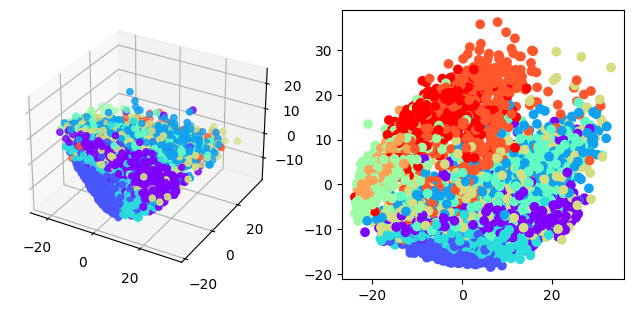

In [17]:
pca = PCA(n_components=3)

# Fit the PCA fnn to the data
pca.fit(train_data_np)

# Transform the data
train_data_pca = pca.transform(train_data_np)

# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_pca[:,0], train_data_pca[:,1], train_data_pca[:,2], c=labels_np, cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_pca[:,0], train_data_pca[:,1], c=labels_np, cmap='rainbow')
plt.show()

# A more interactive plot with plotly
fig = go.Figure(data=[go.Scatter3d(x=train_data_pca[:,0], y=train_data_pca[:,1], z=train_data_pca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()

### __RBF PCA__ 

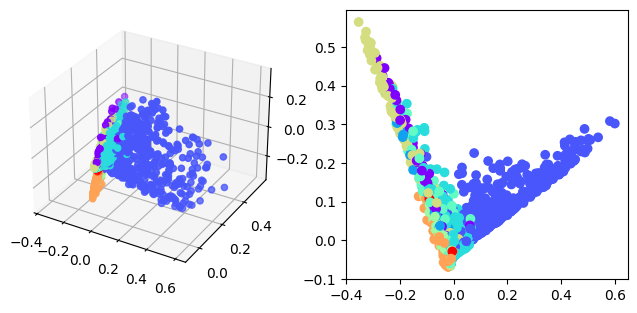

In [19]:
# Perform PCA with gaussian kernel
kpca = KernelPCA(n_components=3, kernel='rbf', gamma=0.01)
train_data_kpca = kpca.fit_transform(train_data_np)

# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], train_data_kpca[:,2], c=labels_np, cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], c=labels_np, cmap='rainbow')
plt.show()

# A more interactive plot with plotly
fig = go.Figure(data=[go.Scatter3d(x=train_data_kpca[:,0], y=train_data_kpca[:,1], z=train_data_kpca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()

### Custom kernel

In [84]:
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.metrics.pairwise import polynomial_kernel
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import linear_kernel
from scipy.linalg import eigh

def get_gram(x_train_n):
        rbfkernel = rbf_kernel(x_train_n,x_train_n, gamma=3)
        rbfkernel1 = rbf_kernel(x_train_n,x_train_n, gamma=0.002)
        sigkernel = sigmoid_kernel(x_train_n,x_train_n,gamma=5, coef0=8)
        sigkernel1 = sigmoid_kernel(x_train_n,x_train_n,gamma=0.03, coef0=0.9)
        linkernel = linear_kernel(x_train_n,x_train_n)

        gram = sigkernel*(rbfkernel) + sigkernel1 
        return gram

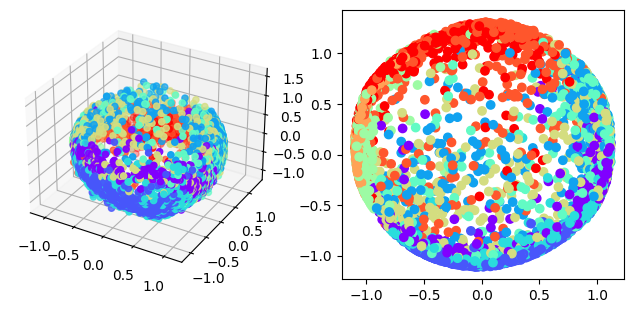

In [88]:

gram = get_gram(train_data_np)
kpca = KernelPCA(n_components=3, kernel='precomputed')
train_data_kpca = kpca.fit_transform(gram)


# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], train_data_kpca[:,2], c=labels_np, cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], c=labels_np, cmap='rainbow')
plt.show()

fig = go.Figure(data=[go.Scatter3d(x=train_data_kpca[:,0], y=train_data_kpca[:,1], z=train_data_kpca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()

### Sigmoid kernel

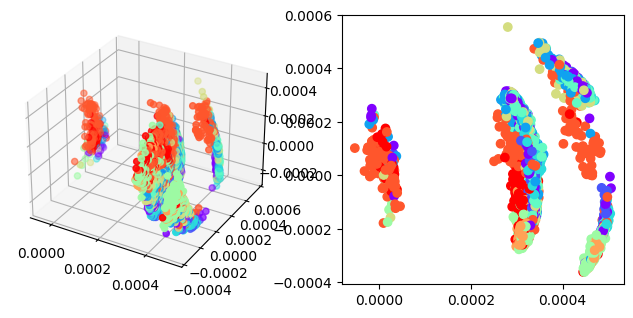

In [87]:
kpca = KernelPCA(n_components=3, kernel='sigmoid', coef0=8.5)
train_data_kpca = kpca.fit_transform(train_data_np)

# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], train_data_kpca[:,2], c=labels_np, cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], c=labels_np, cmap='rainbow')
plt.show()

fig = go.Figure(data=[go.Scatter3d(x=train_data_kpca[:,0], y=train_data_kpca[:,1], z=train_data_kpca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()

### Cosine kernel

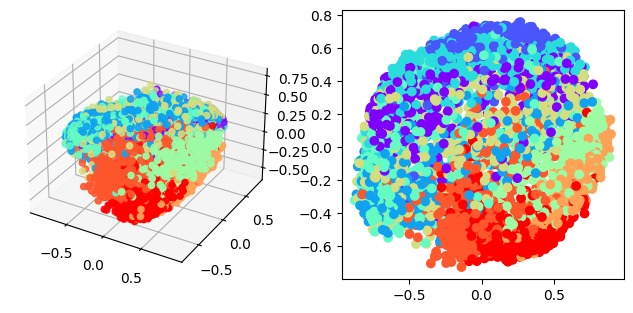

In [35]:
kpca = KernelPCA(n_components=3, kernel='cosine')
train_data_kpca = kpca.fit_transform(train_data_np)

# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], train_data_kpca[:,2], c=labels_np, cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], c=labels_np, cmap='rainbow')
plt.show()

fig = go.Figure(data=[go.Scatter3d(x=train_data_kpca[:,0], y=train_data_kpca[:,1], z=train_data_kpca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()


### Polynomial kernel

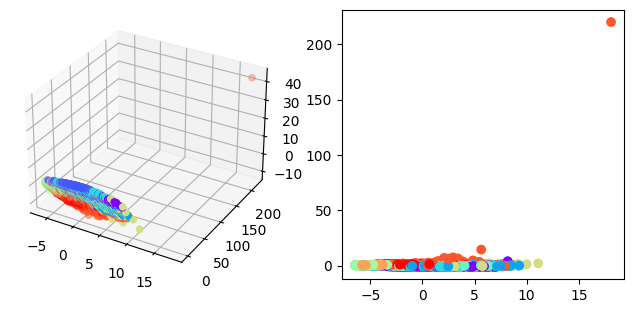

In [124]:

# Perform PCA with polynomial kernel
kpca = KernelPCA(n_components=10, kernel='poly',gamma=0.001, degree=3, coef0=5)
train_data_kpca = kpca.fit_transform(train_data_np)

# plot side by side the 3d plot and the 2d plot
fig = plt.figure(figsize=(8,3.5))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], train_data_kpca[:,2], c=labels_np , cmap='rainbow')
ax = fig.add_subplot(122)
ax.scatter(train_data_kpca[:,0], train_data_kpca[:,1], c=labels_np, cmap='rainbow')
plt.show()

# A more interactive plot with plotly
fig = go.Figure(data=[go.Scatter3d(x=train_data_kpca[:,0], y=train_data_kpca[:,1], z=train_data_kpca[:,2], mode='markers', marker=dict(size=2, color=labels_np, colorscale='rainbow', opacity=0.8))])
fig.show()

In [51]:
explained_variance = np.var(train_data_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

print('Explained variance ratio: ', explained_variance_ratio)
print('Total explained variance: ', np.cumsum(explained_variance_ratio))

Explained variance ratio:  [0.53090906 0.3383323  0.13075864]
Total explained variance:  [0.53090906 0.86924136 1.        ]


### Choosing the best kernel
We can see that the best kernels are the linear and the polynomial one. It is not easy to understand which one is the best. Probably with a better intuition we could construct a better kernel that is able to separate the data better. We also tried some different kernel manually summing other kernels, however the results are comparable with the linear one and we will use the linear kernel for the rest of the notebook, since it is the simplest one and it is also the fastest to compute. The __key__ point here is to find the best kernel: in order to do that we may need a good intuition of the data.

## Section 2: Bridging *unsupervised* and *supervised*
In this section we perform a pca choosed in the previous section and we use the first 10 principal components to assign a label to each image. In order to assign a label to each image we map the "cluster label" to the most frequent (true) label in the cluster. We firstly define functions to perform the clustering on the trasformed data and to assign the labels to each cluster.

In [5]:
def map_kmeans_labels(kmeans_labels, true_labels):
    """
    Maps the KMeans labels to the same order as the true labels.
    """
    unique_labels = np.unique(kmeans_labels)
    label_map = {}
    for label in unique_labels:
        mask = (kmeans_labels == label)
        true_label_counts = np.bincount(true_labels[mask])
        true_label = np.argmax(true_label_counts)
        label_map[label] = true_label
    mapped_labels = np.array([label_map[label] for label in kmeans_labels])
    return mapped_labels, label_map

def plot_clustering(data, mapped_labels, true_labels, title):
    """
    Plots the clustering results.
    """
    #2d plot
    #2d plot
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121)
    ax.scatter(data[:,0], data[:,1], c=mapped_labels, cmap='rainbow')
    ax.set_title('Mapped Labels')
    ax = fig.add_subplot(122)
    ax.scatter(data[:,0], data[:,1], c=true_labels, cmap='rainbow')
    ax.set_title('True Labels')
    fig.suptitle(title)
    plt.show()

    #3d plot
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=mapped_labels, cmap='rainbow')
    ax.set_title('Mapped Labels')
    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2], c=true_labels, cmap='rainbow')
    ax.set_title('True Labels')
    fig.suptitle(title)
    plt.show()


def perform_clustering_and_plot(data, labels, kmeans, fit="true"):
    """
    Performs KMeans clustering on the data and plots the results.
    """
    
    if fit == "true":
        kmeans.fit(data)
        mapped_labels, label_map = map_kmeans_labels(kmeans.labels_, labels)
        unmpapped_labels = kmeans.labels_
    else:
        unmpapped_labels = kmeans.predict(data)
        mapped_labels, label_map = map_kmeans_labels(unmpapped_labels, labels)

    # print the accuracy
    print('Accuracy: {:.2f}%'.format(np.mean(mapped_labels == labels) * 100))

    plot_clustering(data, mapped_labels, labels, 'KMeans Clustering')
    return mapped_labels, unmpapped_labels, label_map

def perform_clustering_and_plot_EMM(data, labels, emm):
    """
    Performs EMM clustering on the data and plots the results.
    """
    emm.fit(data)
    unmapped_labels = emm.predict(data)
    mapped_labels, label_map = map_kmeans_labels(unmapped_labels, labels)
    # print the accuracy
    print('Accuracy: {:.2f}%'.format(np.mean(mapped_labels == labels) * 100))

    plot_clustering(data, mapped_labels, labels, 'EMM Clustering')

    return mapped_labels, unmapped_labels , label_map

#### __Assigning labels PCA__

/home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 55.24%


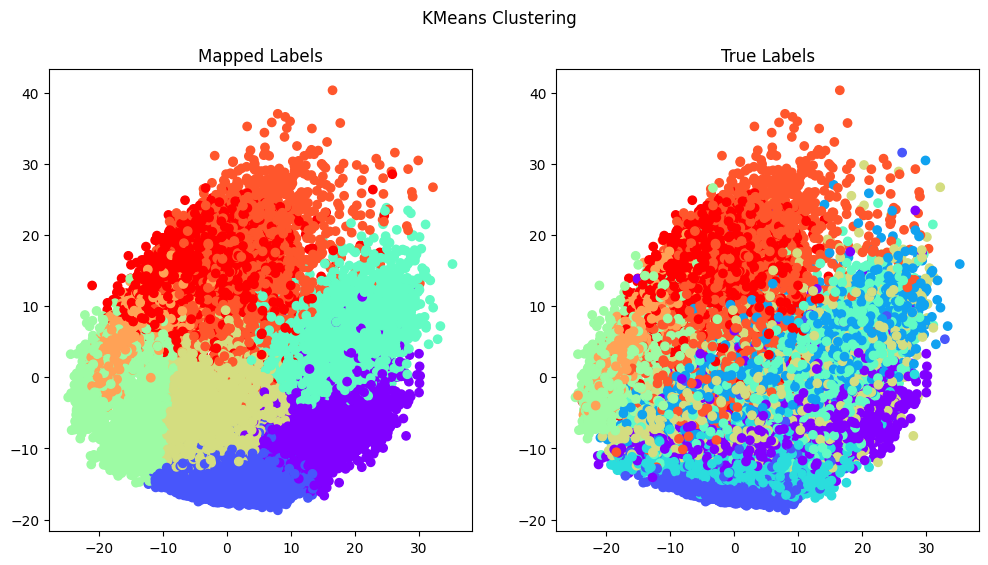

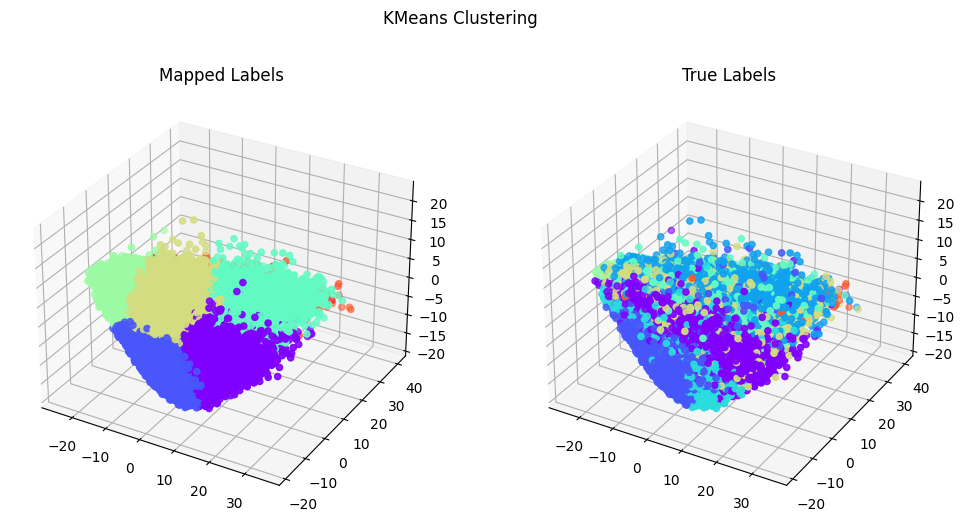

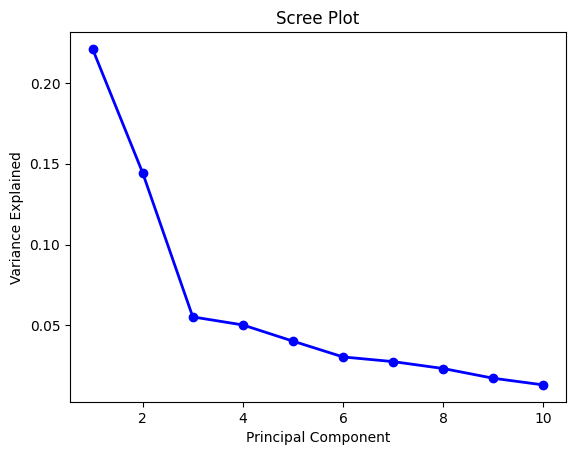

In [7]:
# train_data_np =  KernelPCA(n_components=10, kernel='poly', gamma=0.0001, coef0=10).fit_transform(train_data_np)
pca = PCA(n_components=10)
train_data_pca = pca.fit_transform(train_data_np)

# train_data_pca = np.load('poly_pca_fitted_data.npy')
# np.save('poly_pca_fitted_data.npy', train_data_pca)
# train_data_pca = KernelPCA(n_components=10, kernel='rbf', gamma=0.1).fit_transform(train_data_np)

# Perform KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
mapped_labels, unmapped_labels, label_map = perform_clustering_and_plot(train_data_pca, labels_np, kmeans)

# plot the cumulative sum of the eigenvalues
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()



As we can see, the accuracy is not very high. This is due to the fact that the PCA is not able to separate the data very well. As before, we may try to construct a better kernel that is able to understand the geometry of the data better. We also try to use different clustering algorithms (EM), but the results are comparable.

# Section 3: (Supervised) classification
In this section we perform a classification on the (trasformed) data. We use a SVM with different kernels and we compare the results. Then, we use a feed-forward neural network and a CNN to classify the data.

Fristly, we define a custum split function to split the training set into training and validation sets:

In [8]:
def split_data(train_data_np, unmapped_labels, labels_np):
    if unmapped_labels is None:
        unmapped_labels = labels_np
    n = len(train_data_np)
    train_data = train_data_np[:int(n*0.8)]
    eval_data = train_data_np[int(n*0.8):]
    train_labels = unmapped_labels[:int(n*0.8)]
    eval_labels = unmapped_labels[int(n*0.8):]
    real_labels = labels_np[int(n*0.8):]
    return train_data, eval_data, train_labels, eval_labels, real_labels

Then, we try different kernels for the SVM:

#### __Kernel SVM__

In [9]:
# create train and evaluation data using np data along with the mapped labels
train_data, eval_data, train_labels, eval_labels, real_labels = split_data(train_data_np, unmapped_labels, labels_np)

In [10]:
# linear SVM
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# create the model
svm = LinearSVC(C=1.0, max_iter=50000)

# fit the fnn
svm.fit(train_data, train_labels)

# predict on the evaluation data
eval_pred = svm.predict(eval_data)

# print the accuracy
print('Accuracy: {:.2f}%'.format(accuracy_score(eval_labels, eval_pred) * 100))


Accuracy: 89.55%


/home/francesco/anaconda3/envs/torch/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [11]:
# gaussian SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# create the model
svm = SVC(C=1.0, gamma=0.005, kernel='rbf')

# fit the model
svm.fit(train_data, train_labels)

# predict on the evaluation data
eval_pred = svm.predict(eval_data)

# print the accuracy
print('Accuracy: {:.2f}%'.format(accuracy_score(eval_labels, eval_pred) * 100))

Accuracy: 93.50%


In [12]:
# polynomial SVM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# create the model
svm = SVC(C=1.0, kernel='poly')

# fit the model
svm.fit(train_data, train_labels)

# predict on the evaluation data
eval_pred = svm.predict(eval_data)

# print the accuracy
print('Accuracy: {:.2f}%'.format(accuracy_score(eval_labels, eval_pred) * 100))

Accuracy: 96.35%


We expect that the linear and the polynomial kernel are the best ones, since they are the best one on the PCA. The results show that the polynomial kernel is the best one for the SVM. However, we may expect a lower accuracy for the gaussian kernel, since our intuition coming from the PCA is that the gaussian kernel is not able to separate the data very well.

#### __Fully Connected NN__

Now we try to use a fully connected NN. We use a 3 layers NN with 512 and 256 hidden neurons. We use the ReLU activation function.

In [11]:
# create train and evaluation data using np data along with the mapped labels but with torch tensors
from sklearn.model_selection import train_test_split
train_data, eval_data, train_labels, eval_labels,  real_labels = split_data(train_data_np, unmapped_labels, labels_np)

# normalize the data with transform
train_data = torch.from_numpy(train_data).float()
eval_data = torch.from_numpy(eval_data).float()
train_labels = torch.from_numpy(train_labels).long()
eval_labels = torch.from_numpy(eval_labels).long()

In [12]:
## create a fully connected neural network with 3 hidden layers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
# create train loop for the neural network using cuda

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    saved_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        # save the loss each 20 batches
        if batch_idx % 20 == 0:
            saved_loss.append(loss.item())

    return saved_loss

    
   
# create evaluation loop for the neural network using cuda
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy



In [14]:
# train the neural network
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


fnn = FNN()

#print number of parameters
print('Number of parameters: {}'.format(sum(p.numel() for p in fnn.parameters())))

# create the optimizer
optimizer = optim.Adam(fnn.parameters(), lr=0.001, weight_decay=1e-5)

# create the loss function
criterion = nn.CrossEntropyLoss()

# create the dataset
train_dataset = TensorDataset(train_data, train_labels)
eval_dataset = TensorDataset(eval_data, eval_labels)

# create the data loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False)

# train the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
fnn.to(device)

total_loss = []
total_accuracy = []
total_per_batch_loss = []
total_train_loss = []
total_train_accuracy = []
for epoch in range(15):
    per_batch_loss = train(fnn, train_loader, optimizer, criterion, device, epoch)
    train_loss, train_accuracy = evaluate(fnn, train_loader, criterion, device)
    test_loss, test_accuracy = evaluate(fnn, eval_loader, criterion, device)
    print('Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
    # save loss and accuracy for plotting
    total_loss.append(test_loss)
    total_accuracy.append(test_accuracy)
    total_train_loss.append(train_loss)
    total_per_batch_loss.append(per_batch_loss)
    total_train_accuracy.append(train_accuracy)



Number of parameters: 535818
Epoch: 0, Train Loss: 0.0007, Train Accuracy: 96.25% Test Loss: 0.0008, Test Accuracy: 95.92%
Epoch: 1, Train Loss: 0.0007, Train Accuracy: 96.04% Test Loss: 0.0011, Test Accuracy: 94.65%
Epoch: 2, Train Loss: 0.0007, Train Accuracy: 96.48% Test Loss: 0.0011, Test Accuracy: 94.75%
Epoch: 3, Train Loss: 0.0004, Train Accuracy: 98.12% Test Loss: 0.0008, Test Accuracy: 96.22%
Epoch: 4, Train Loss: 0.0003, Train Accuracy: 98.48% Test Loss: 0.0008, Test Accuracy: 96.30%
Epoch: 5, Train Loss: 0.0005, Train Accuracy: 97.41% Test Loss: 0.0011, Test Accuracy: 95.25%
Epoch: 6, Train Loss: 0.0008, Train Accuracy: 96.78% Test Loss: 0.0013, Test Accuracy: 94.72%
Epoch: 7, Train Loss: 0.0003, Train Accuracy: 98.53% Test Loss: 0.0009, Test Accuracy: 96.38%
Epoch: 8, Train Loss: 0.0002, Train Accuracy: 99.01% Test Loss: 0.0008, Test Accuracy: 96.65%
Epoch: 9, Train Loss: 0.0002, Train Accuracy: 98.84% Test Loss: 0.0009, Test Accuracy: 96.88%
Epoch: 10, Train Loss: 0.0004, 

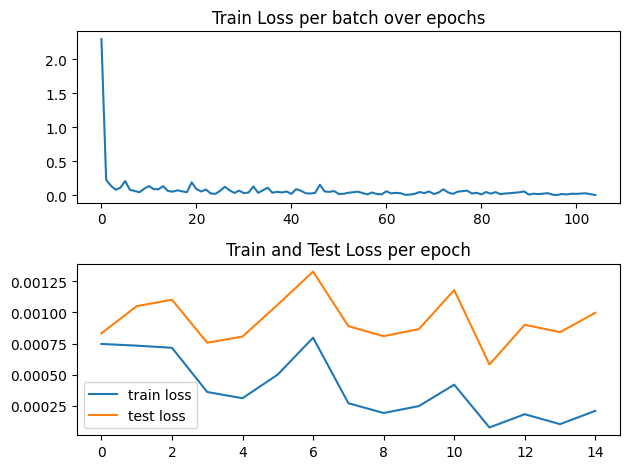

In [15]:
# check if is a list of lists
if isinstance(total_per_batch_loss[0], list):
    total_per_batch_loss = [ item for elem in total_per_batch_loss for item in elem]
# Plot 1 - Train Loss per batch over epochs
plt.subplot(211)
plt.plot(total_per_batch_loss)
plt.title('Train Loss per batch over epochs')

# Plot 2 - Train and Test Loss per epoch

plt.subplot(212)
plt.plot(total_train_loss, label='train loss')
plt.plot(total_loss, label='test loss')
plt.title('Train and Test Loss per epoch')
plt.legend()


# Display the figure
plt.tight_layout()
plt.show()


#### __CNN__

Then, we train a simple CNN with two convolutioanl layer and two linear layers. We use the ReLU activation function and the max pooling. We also use the dropout to avoid overfitting.

In [23]:
## reshape the data from 1x784 to 1x28x28
train_data = train_data.view(-1, 1, 28, 28)
eval_data = eval_data.view(-1, 1, 28, 28)

In [24]:

import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # add dropout
        self.dropout = nn.Dropout(0.2)
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
    

        return x



In [25]:
cnn = CNN()

# print number of parameters
print('Number of parameters: {}'.format(sum([p.numel() for p in cnn.parameters()])))

# create the optimizer
optimizer = optim.Adam(cnn.parameters(), lr=0.001, weight_decay=1e-5)

# create the loss function
criterion = nn.CrossEntropyLoss()


# create the dataset
train_dataset = TensorDataset(train_data, train_labels)
eval_dataset = TensorDataset(eval_data, eval_labels)

# create the data loader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=128, shuffle=False)

# train the cnn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cnn.to(device)

total_loss = []
total_accuracy = []
total_per_batch_loss = []
total_train_loss = []
total_train_accuracy = []
for epoch in range(15):
    per_batch_loss = train(cnn, train_loader, optimizer, criterion, device, epoch)
    train_loss, train_accuracy = evaluate(cnn, train_loader, criterion, device)
    test_loss, test_accuracy = evaluate(cnn, eval_loader, criterion, device)
    print('Epoch: {}, Train Loss: {:.4f}, Train Accuracy: {:.2f}% Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(epoch, train_loss, train_accuracy, test_loss, test_accuracy))
    # save loss and accuracy for plotting
    total_loss.append(test_loss)
    total_accuracy.append(test_accuracy)
    total_train_loss.append(train_loss)
    total_per_batch_loss.append(per_batch_loss)
    total_train_accuracy.append(train_accuracy)



Number of parameters: 421642
Epoch: 0, Train Loss: 0.0015, Train Accuracy: 92.31% Test Loss: 0.0014, Test Accuracy: 92.55%
Epoch: 1, Train Loss: 0.0007, Train Accuracy: 96.08% Test Loss: 0.0008, Test Accuracy: 95.72%
Epoch: 2, Train Loss: 0.0005, Train Accuracy: 97.53% Test Loss: 0.0006, Test Accuracy: 97.33%
Epoch: 3, Train Loss: 0.0005, Train Accuracy: 97.10% Test Loss: 0.0007, Test Accuracy: 96.58%
Epoch: 4, Train Loss: 0.0006, Train Accuracy: 96.66% Test Loss: 0.0007, Test Accuracy: 95.95%
Epoch: 5, Train Loss: 0.0003, Train Accuracy: 98.71% Test Loss: 0.0005, Test Accuracy: 97.83%
Epoch: 6, Train Loss: 0.0003, Train Accuracy: 98.50% Test Loss: 0.0005, Test Accuracy: 97.17%
Epoch: 7, Train Loss: 0.0003, Train Accuracy: 98.32% Test Loss: 0.0006, Test Accuracy: 96.88%
Epoch: 8, Train Loss: 0.0006, Train Accuracy: 96.55% Test Loss: 0.0009, Test Accuracy: 95.70%
Epoch: 9, Train Loss: 0.0004, Train Accuracy: 97.98% Test Loss: 0.0006, Test Accuracy: 97.08%
Epoch: 10, Train Loss: 0.0004, 

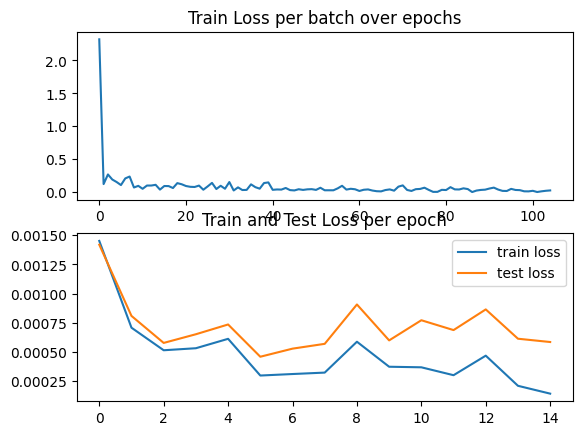

In [26]:
# check if is a list of lists
if isinstance(total_per_batch_loss[0], list):
    total_per_batch_loss = [ item for elem in total_per_batch_loss for item in elem]
# Plot 1 - Train Loss per batch over epochs
plt.subplot(211)
plt.plot(total_per_batch_loss)
plt.title('Train Loss per batch over epochs')

# Plot 2 - Train and Test Loss per epoch
plt.subplot(212)
plt.plot(total_train_loss, label='train loss')
plt.plot(total_loss, label='test loss')
plt.title('Train and Test Loss per epoch')
plt.legend()


### Section 4: Wrap-up!

In this section we evaluate the self-supervised pipline with the ground truth of the test set. We use the best model for each method and we compare the results.

#### __Analysis of the mapped labels__

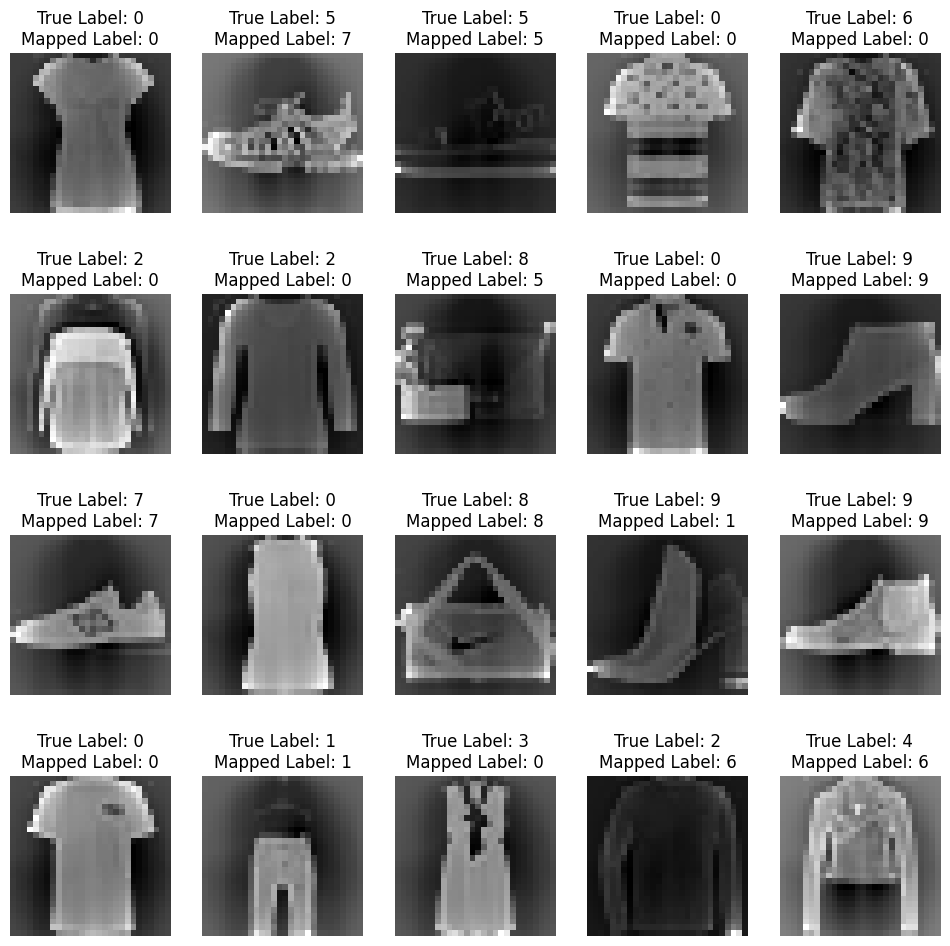

In [19]:
# same as before but plot a grid of 20 images
fig = plt.figure(figsize=(12,12))
# get random 20 indexs
idxs = np.random.randint(0, len(train_data_np), 20)
for j, i in enumerate(idxs):
    ax = fig.add_subplot(4,5,j+1)
    ax.imshow(train_data_np[i].reshape(28,28), cmap='gray')
    ax.set_title('True Label: {}\nMapped Label: {}'.format(labels_np[i], mapped_labels[i]))
    ax.axis('off')
plt.show()

#### __Accuracy between predicted labels and true labels__

In [28]:
def pipeline(test_data_np, test_labels_np, map_labels = True):

    # flatten the data
    test_data_np = test_data_np.reshape(test_data_np.shape[0], -1)

    # scale the data
    test_data_np = scaler.transform(test_data_np)

    # get the prediction
    test_pred_svm = svm.predict(test_data_np)

    # same for the fnn
    # test_data_np to torch tensor
    test_data = torch.from_numpy(test_data_np).float()

    test_pred_fnn = fnn(test_data.to(device))
    test_pred_fnn = test_pred_fnn.argmax(dim=1, keepdim=True)
    test_pred_fnn = test_pred_fnn.cpu().numpy()
    # reshape the predictions
    test_pred_fnn = test_pred_fnn.reshape(-1)



    torch.cuda.empty_cache()

    # same for the cnn
    test_data = test_data.view(-1, 1, 28, 28)

    with torch.no_grad():
        cnn.eval()
        test_pred_cnn = cnn(test_data.to(device))
    test_pred_cnn = test_pred_cnn.argmax(dim=1, keepdim=True)
    test_pred_cnn = test_pred_cnn.cpu().numpy()
    # reshape the predictions
    test_pred_cnn = test_pred_cnn.reshape(-1)

    if map_labels:
        # map the labels back to the original
        test_pred_svm = [label_map[i] for i in test_pred_svm]
        test_pred_fnn = [label_map[i] for i in test_pred_fnn]
        test_pred_cnn = [label_map[i] for i in test_pred_cnn]


    # print the accuracy eval_pred vs mapped eval labels
    print('SVM Accuracy: {:.2f}%'.format(accuracy_score(test_pred_svm, test_labels_np) * 100))
    print('FNN Accuracy: {:.2f}%'.format(accuracy_score(test_pred_fnn, test_labels_np) * 100))
    print('CNN Accuracy: {:.2f}%'.format(accuracy_score(test_pred_cnn, test_labels_np) * 100))

    return 


In [29]:
#free cuda memory
torch.cuda.empty_cache()

pipeline(test_data_np, test_labels_np)

SVM Accuracy: 55.53%
FNN Accuracy: 55.32%
CNN Accuracy: 55.48%


As we can see, the result are pretty well, considering that the accuracy of mapping the lables is ~ $58\%$. The problem here is to find the best kernel of the PCA.  

### Section 5: A *fully-supervised* approach

In this section we train all the models with the true labels. We compare the results with the previous section.

In [30]:
def train_all_and_evaluate(train_data_np, labels_np,  test_data_np, test_labels_np):

    # flatten the data
    test_data_np = test_data_np.reshape(test_data_np.shape[0], -1)
    
    #scale the data
    test_data_np = scaler.transform(test_data_np)

    # split in order to train with the same amount of data (and the same data too)
    train_data, _ , train_labels, _, _ = split_data(train_data_np, unmapped_labels = None,  labels_np = labels_np,)

    ## SVM
    print('Training SVM...')
    svm.fit(train_data, train_labels)
    svm_preds = svm.predict(test_data_np)

    ##### ANNs

    # train_data_np to torch tensor
    train_data = torch.from_numpy(train_data).float()
    train_labels = torch.from_numpy(train_labels).long()
    test_data = torch.from_numpy(test_data_np).float()

    # create the dataset
    train_dataset = TensorDataset(train_data, train_labels)
    
    # create the data loader
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    ## FNN
    fnn = FNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(fnn.parameters(), lr=0.001)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    fnn.to(device)
    fnn.train()
    for epoch in tqdm(range(15), desc='FNN Training') :
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = fnn(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()

    fnn.eval()
    with torch.no_grad():
        fnn_preds = fnn(test_data.to(device))
    fnn_preds = fnn_preds.argmax(dim=1, keepdim=True)
    fnn_preds = fnn_preds.cpu().numpy()
    # reshape the predictions
    fnn_preds = fnn_preds.reshape(-1)

    ## CNN
    # empty cuda memory
    torch.cuda.empty_cache()

    # reshape the data
    train_data = train_data.view(-1, 1, 28, 28)
    test_data = test_data.view(-1, 1, 28, 28)

    # create the dataset
    train_dataset = TensorDataset(train_data, train_labels)
    
    # create the data loader
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    cnn = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    cnn.to(device)
    cnn.train()
    for epoch in tqdm(range(15), desc='CNN Training'):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = cnn(data)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
    
    cnn.eval()
    with torch.no_grad():
        cnn_preds = cnn(test_data.to(device))
    cnn_preds = cnn_preds.argmax(dim=1, keepdim=True)
    cnn_preds = cnn_preds.cpu().numpy()

    # reshape the predictions
    fnn_preds = fnn_preds.reshape(-1)

    #### EVALUATION, print the accuracy eval_pred vs mapped eval labels
    print('SVM Accuracy: {:.2f}%'.format(accuracy_score(svm_preds, test_labels_np) * 100))
    print('FNN Accuracy: {:.2f}%'.format(accuracy_score(fnn_preds, test_labels_np) * 100))
    print('CNN Accuracy: {:.2f}%'.format(accuracy_score(cnn_preds, test_labels_np) * 100))

    return

In [31]:
train_all_and_evaluate(train_data_np, labels_np,  test_data_np, test_labels_np)

Training SVM...


CNN Training: 100%|██████████| 15/15 [00:07<00:00,  2.03it/s]

SVM Accuracy: 84.12%
FNN Accuracy: 85.93%
CNN Accuracy: 89.83%


We may expect a better results. One possible reason is that the mapping of the labals lead to a simpler geometry of the data that our classifiers understand better. It is interesting to see that in this case the CNN performs better than the SVM. This is probably to the fact that the CNN is able to learn the geometry of the data and it is able to cope better with a more complex and unknown geometry. 